## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте, вы заказываете такси из одной точки Нью-Йорка в другую, причем необязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких, какЖ откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная и начальная точки маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Во время выполнения проекта будут отработаны навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Условно разделим признаки на несколько групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведём признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда. 

Определим временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data_copy = taxi_data.copy()
taxi_data_copy['pickup_datetime'] = pd.to_datetime(taxi_data_copy['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print('Самый первый день в этом датасете:', taxi_data_copy['pickup_datetime'].min())
print('Самый последний день в этом датасете:', taxi_data_copy['pickup_datetime'].max())

Самый первый день в этом датасете: 2016-01-01 00:00:17
Самый последний день в этом датасете: 2016-06-30 23:59:39


### 2.2
Посмотрим на пропуски. Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [4]:
taxi_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


Видим, что в данных нет пропусков. Это очень хорошо!

### 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки?

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [5]:
print('В данных {0} уникальных таксопарков.'.format(taxi_data_copy['vendor_id'].nunique()))
print('Максимальное число пассажиров за одну поездку - {0}.'.format(taxi_data_copy['passenger_count'].max()))
print('Средняя длительность поездки составляет - {0} секунд, а медианная - {1} секунды'.format(
    np.round(taxi_data_copy['trip_duration'].mean()), np.round(taxi_data_copy['trip_duration'].median())))
print('Максимальное время поездки составляет - {0} секунды, а минимальное - {1} секунда'.format(
    taxi_data_copy['trip_duration'].max(), taxi_data_copy['trip_duration'].min()))

В данных 2 уникальных таксопарков.
Максимальное число пассажиров за одну поездку - 9.
Средняя длительность поездки составляет - 959.0 секунд, а медианная - 662.0 секунды
Максимальное время поездки составляет - 3526282 секунды, а минимальное - 1 секунда


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### 2.4
Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день?

In [6]:
def add_datetime_features(data_frame: pd.DataFrame):
    """Функция, добавляющая к исходному датасету 3 столбца: дата включения счётчика, час включения счётчика и день недели включения счётчика.

    Args:
        data_frame (pd.DataFrame): исходный датасет.

    Returns:
        pd.DataFrame: преобразованный датасет.
    """
    pickup_info = data_frame['pickup_datetime']
    data_frame['pickup_date'] = pickup_info.dt.date
    data_frame['pickup_hour'] = pickup_info.dt.hour
    data_frame['pickup_day_of_week'] = pickup_info.dt.day_of_week
    return data_frame

taxi_data_mod = add_datetime_features(taxi_data_copy)
print('В субботу было совершено {0} поездок.'.format(taxi_data_mod[taxi_data_mod['pickup_day_of_week'] == 5]['id'].count()))
print('В среднем в день совершается {0} поездок.'.format(np.round(taxi_data_mod.groupby(by='pickup_date')['id'].count().mean())))

В субботу было совершено 220868 поездок.
В среднем в день совершается 8015.0 поездок.


### 2.5
Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни?


In [7]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

def add_holiday_features(data: pd.DataFrame, holiday: pd.DataFrame):
    """Функция, добавляющая к исходному датасету столбец, говорящий о том, является ли день начала поездки праздничным или нет.

    Args:
        data (pd.DataFrame): исходный датасет.
        holiday (pd.DataFrame): датасет с информацией о праздничных днях.

    Returns:
        pd.DataFrame: преобразованный датасет.
    """
    holidays = holiday['date'].unique()
    holidays = pd.to_datetime(holidays).date
    data['pickup_holiday'] = data['pickup_date'].apply(lambda arg: 1 if arg in holidays else 0)
    return data

taxi_data_mod = add_holiday_features(taxi_data_mod, holiday_data)
print('Медианная длительность поездки на такси в праздничные дни составляет {0} секунд.'.format(
    np.round(taxi_data_mod[taxi_data_mod['pickup_holiday'] == 1]['trip_duration'].median())))

Медианная длительность поездки на такси в праздничные дни составляет 585.0 секунд.


### 2.6
Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [8]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

def add_osrm_features(data: pd.DataFrame, osrm: pd.DataFrame):
    osrm = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    return data.merge(right=osrm, how='left', on='id')

taxi_data_mod = add_osrm_features(taxi_data_mod, osrm_data)
print('Разница между медианной длительностью поездки в данных и медианной длительностью поездки из OSRM равна {0} секундам.'.format(
    np.round(taxi_data_mod['trip_duration'].median() - taxi_data_mod['total_travel_time'].median())))
print('После объединения таблиц имеется {0} пропуска.'.format(taxi_data_mod.isna().sum().sum()))

Разница между медианной длительностью поездки в данных и медианной длительностью поездки из OSRM равна 372.0 секундам.
После объединения таблиц имеется 3 пропуска.


С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Введём в наш анализ расстояние по [формуле Хаверсина](http://espressocode.top/haversine-formula-to-find-distance-between-two-points-on-a-sphere).

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

В чём разница между расстоянием Хаверсина и расстоянием из OSRM? Расстояние, вычисляемое в OSRM, — это кратчайший суммарный путь, пройденный по дорожным разметкам.

Реализуем фукнции, которые будут считать расстояние Хаверсина между двуями точками, а также направление движения автомобиля.

In [9]:
def get_haversine_distance(lat1:float, lng1:float, lat2:float, lng2:float):
    """Функция считает расстояние Хаверсина между двумя точками.

    Args:
        lat1 (float): широта первой точки
        lng1 (float): долгота первой точки
        lat2 (float): широта второй точки
        lng2 (float): долгота второй точки

    Returns:
        float: расстояние Хаверсина.
    """
    # перевод углов в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    EARTH_RADIUS = 6371 
    # подсчет кратчайшего расстояния h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1:float, lng1:float, lat2:float, lng2:float):
    """Функция считает направление движения автомобиля (угол пеленга).

    Args:
        lat1 (float): широта первой точки
        lng1 (float): долгота первой точки
        lat2 (float): широта второй точки
        lng2 (float): долгота второй точки

    Returns:
        float: угол пеленга.
    """
    # перевод углов в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # подсчет угла направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Теперь, когда есть методика вычисления дополнительных географических признаков, можно перейти к их созданию.

### 2.7.
Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)?


In [10]:
def add_geographical_features(data: pd.DataFrame):
    """Функция, добавляющая к исходному датафрейму 2 столбца: расстояние Хаверсина и направление движения.

    Args:
        data (pd.DataFrame): исходный датафрейм.

    Returns:
        pd.DataFrame: преобразованный датафрейм.
    """
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], data['pickup_longitude'],
                                                        data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(data['pickup_latitude'], data['pickup_longitude'],
                                            data['dropoff_latitude'], data['dropoff_longitude'])
    return data

taxi_data_mod = add_geographical_features(taxi_data_mod)
print('Медианное расстояние Хаверсина поездок равно {0} километров.'.format(np.round(taxi_data_mod['haversine_distance'].median(), 2)))

Медианное расстояние Хаверсина поездок равно 2.09 километров.


### 2.8.
Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках. Функция должна присваивать каждой поездке номер кластера, рассчитанный по алгоритму кластеризации K-Means и возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [11]:
def add_cluster_features(data:pd.DataFrame):
    """Функция добавляет к датафрейму столбец с номерами кластеров.

    Args:
        data (pd.DataFrame): исходный датафрейм.

    Returns:
        pd.DataFrame: преобразованный датафрейм.
    """
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                        data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    data['geo_cluster'] = kmeans.labels_
    return data

taxi_data_mod = add_cluster_features(taxi_data_mod)
print('В наименьшем по размеру географическом кластере под номером {0} содержится {1} поездки.'.format(
    taxi_data_mod['geo_cluster'].value_counts().index[-1], taxi_data_mod['geo_cluster'].value_counts().min()
))

/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


В наименьшем по размеру географическом кластере под номером 2 содержится 2 поездок.


### 2.9.
Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями?


In [12]:
weather_data = pd.read_csv('data/weather_data.csv')

def add_weather_features(data: pd.DataFrame, weather: pd.DataFrame):
    """Функция добавляет к датафрейму 5 столбцов: значение температуры, видимости, средней скорости ветра, количества осадков и погодных явлений
    в зависимости от дата и времени начала поездки.

    Args:
        data (pd.DataFrame): исходный датафрейм.
        weather (pd.DataFrame): датафрейм с информацией о погоде.

    Returns:
        pd.DataFrame: преобразованный датафрейм.
    """
    weather['time'] = pd.to_datetime(weather['time'], yearfirst=True)
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    data = data.merge(right=weather, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'])
    data = data.drop(columns=['date', 'hour'])
    return data

taxi_data_mod = add_weather_features(taxi_data_mod, weather_data)
print('В снежную погоду было совершено {0} поездок.'.format(taxi_data_mod[taxi_data_mod['events'] == 'Snow']['id'].count()))
print('Пропуски в столбцах с погодными условиями занимают {0}% от общего числа наблюдений.'.format(
    np.round(taxi_data_mod['temperature'].isna().sum() / taxi_data_mod.shape[0] * 100, 2)))

В снежную погоду было совершено 13126 поездок.
Пропуски в столбцах с погодными условиями занимают 0.82% от общего числа наблюдений.


### 2.10.
Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip - заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps - заполним медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков?


In [13]:
def fill_null_weather_data(data: pd.DataFrame):
    """Функция заполняет пропуски в столбцах.

    Args:
        data (pd.DataFrame): исходный датасет.

    Returns:
        pd.DataFrame: преобразованный датасет.
    """
    weather_features = ['temperature', 'visibility', 'wind speed', 'precip']
    for feature in weather_features:
        data[feature] = data[feature].fillna(data.groupby('pickup_date')[feature].transform('median'))
    data['events'] = data['events'].fillna('None')
    orsm_features = ['total_distance', 'total_travel_time', 'number_of_steps']
    for feature in orsm_features:
        data[feature] = data[feature].fillna(data[feature].median())
    return data

taxi_data_mod = fill_null_weather_data(taxi_data_mod)
print('Медианное значение в столбце temperature = {0}.'.format(np.round(taxi_data_mod['temperature'].median(), 1)))

Медианное значение в столбце temperature = 11.1.


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


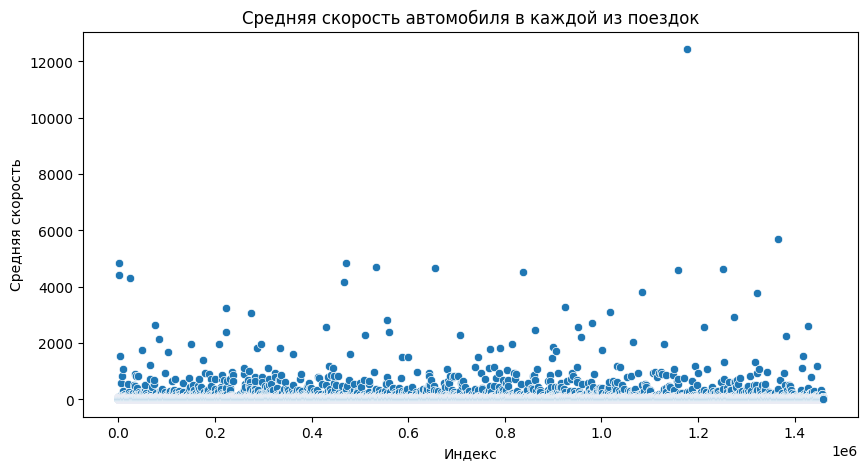

In [14]:
avg_speed = taxi_data_mod['total_distance'] / taxi_data_mod['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_title('Средняя скорость автомобиля в каждой из поездок')
ax.set_xlabel('Индекс')
ax.set_ylabel('Средняя скорость');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты, будет 300 км/ч. 


### 2.11.
Найдём поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

а) Сколько выбросов по признаку длительности поездки удалось найти?

Найдём поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч, и удалим их из данных. 

б) Сколько выбросов по признаку скорости удалось найти?

In [15]:
duration_outliers = taxi_data_mod[taxi_data_mod['trip_duration'] > 60 * 60 * 24]
print('Всего нашлось {0} выброса по признаку длительности поездки.'.format(duration_outliers.shape[0]))
taxi_data_mod = taxi_data_mod.drop(index=duration_outliers.index)

speed_outliers = taxi_data_mod[taxi_data_mod['total_distance'] / taxi_data_mod['trip_duration'] * 3.6 > 300]
print('Всего нашлось {0} выбросов по признаку скорости.'.format(speed_outliers.shape[0]))
taxi_data_mod = taxi_data_mod.drop(index=speed_outliers.index)

Всего нашлось 4 выброса по признаку длительности поездки.
Всего нашлось 407 выбросов по признаку скорости.


## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных; 
* Найдём закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими исследование.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1).$$


In [16]:
taxi_data_mod['trip_duration_log'] = np.log(taxi_data_mod['trip_duration']+1)

### 3.1.
Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным? 
Проверять гипотезу будем с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value?

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

p=0.00
Данные распределены не нормально (мы отвергаем H0)


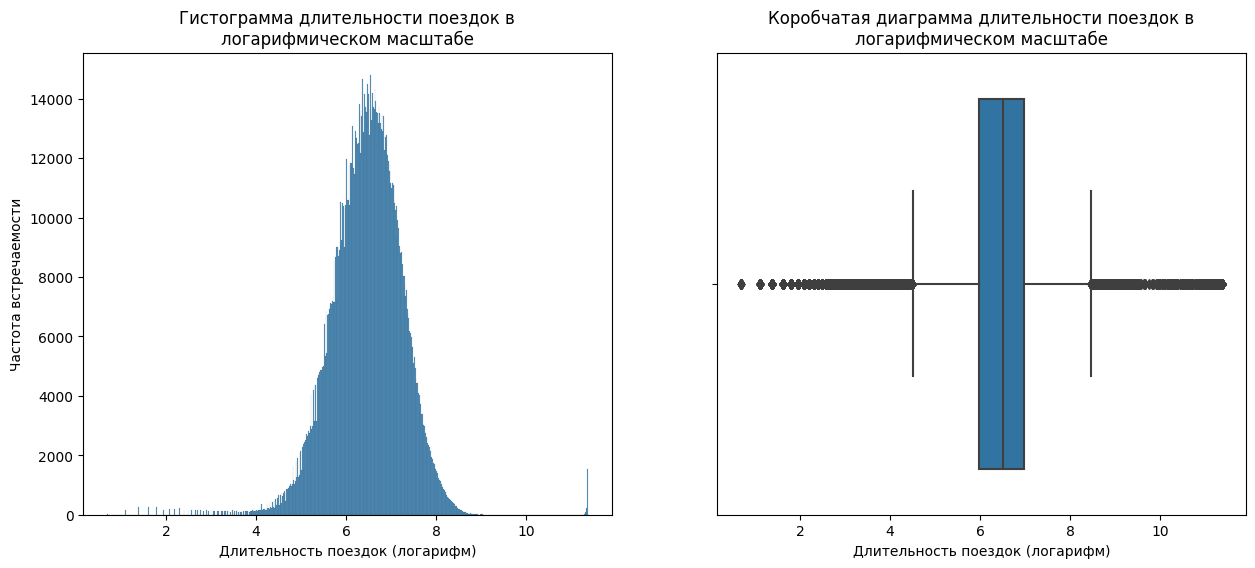

In [18]:
figure, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(data=taxi_data_mod, x='trip_duration_log', ax=axes[0])
sns.boxplot(data=taxi_data_mod, x='trip_duration_log', ax=axes[1])
axes[0].set_title('Гистограмма длительности поездок в\nлогарифмическом масштабе')
axes[0].set_xlabel('Длительность поездок (логарифм)')
axes[0].set_ylabel('Частота встречаемости')
axes[1].set_title('Коробчатая диаграмма длительности поездок в\nлогарифмическом масштабе')
axes[1].set_xlabel('Длительность поездок (логарифм)');

H0 = 'Данные распределены нормально'
Ha = 'Данные распределены не нормально (мы отвергаем H0)'
alpha = 0.05

statistic, p_value = stats.normaltest(taxi_data_mod['trip_duration_log'])
print('p=%.2f' % p_value)

if p_value > alpha / 2:
	print(H0)
else:
	print(Ha)

### 3.2.
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравним два распределения между собой.

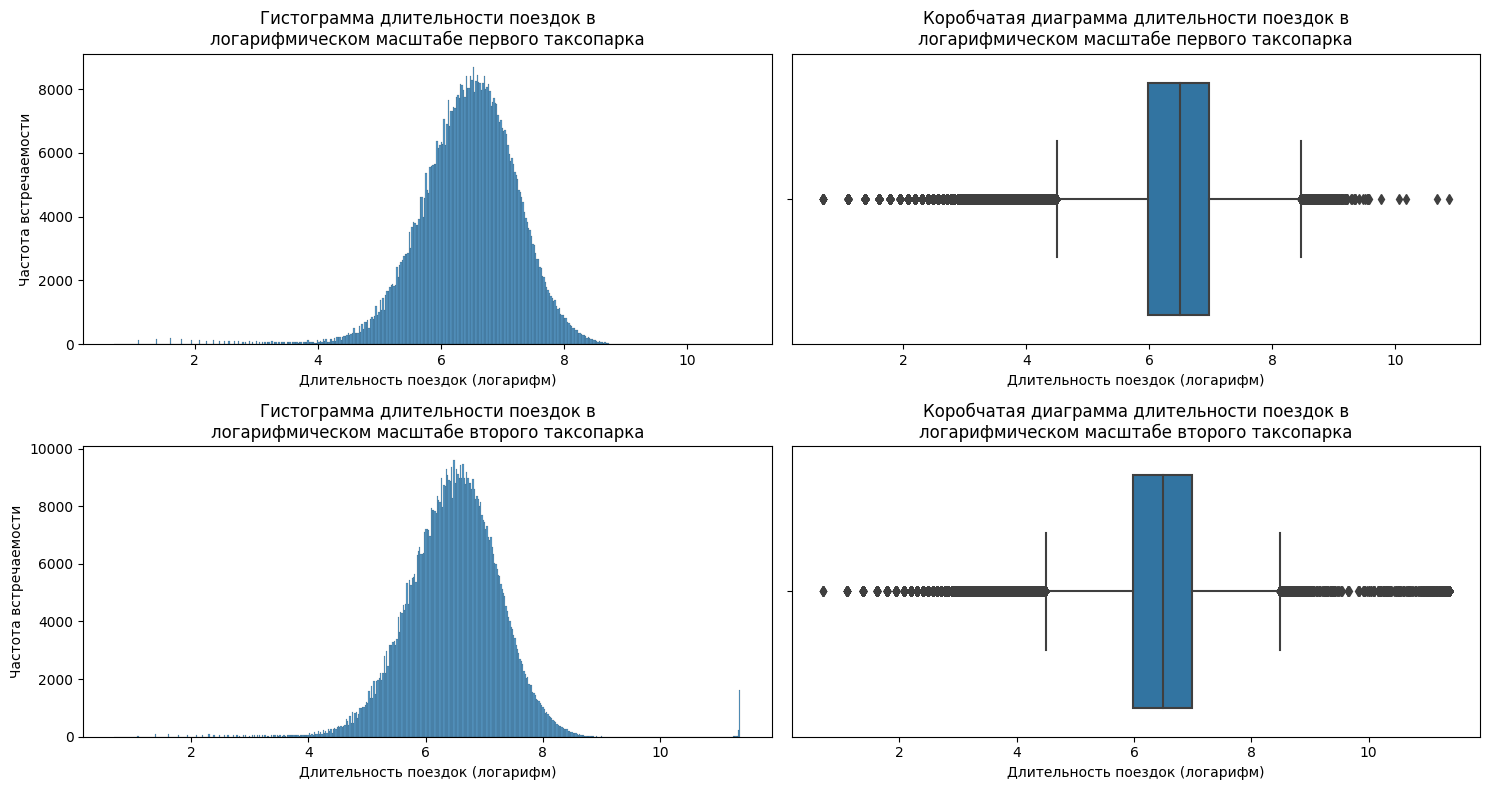

In [17]:
figure, axes = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(data=taxi_data_mod[taxi_data_mod['vendor_id'] == 1], x='trip_duration_log', ax=axes[0][0])
axes[0][0].set_title('Гистограмма длительности поездок в\nлогарифмическом масштабе первого таксопарка')
axes[0][0].set_xlabel('Длительность поездок (логарифм)')
axes[0][0].set_ylabel('Частота встречаемости')

sns.boxplot(data=taxi_data_mod[taxi_data_mod['vendor_id'] == 1], x='trip_duration_log', ax=axes[0][1])
axes[0][1].set_title('Коробчатая диаграмма длительности поездок в\nлогарифмическом масштабе первого таксопарка')
axes[0][1].set_xlabel('Длительность поездок (логарифм)');

sns.histplot(data=taxi_data_mod[taxi_data_mod['vendor_id'] == 2], x='trip_duration_log', ax=axes[1][0])
axes[1][0].set_title('Гистограмма длительности поездок в\nлогарифмическом масштабе второго таксопарка')
axes[1][0].set_xlabel('Длительность поездок (логарифм)')
axes[1][0].set_ylabel('Частота встречаемости')

sns.boxplot(data=taxi_data_mod[taxi_data_mod['vendor_id'] == 2], x='trip_duration_log', ax=axes[1][1])
axes[1][1].set_title('Коробчатая диаграмма длительности поездок в\nлогарифмическом масштабе второго таксопарка')
axes[1][1].set_xlabel('Длительность поездок (логарифм)')

plt.tight_layout();

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### 3.3.
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравним два распределения между собой.

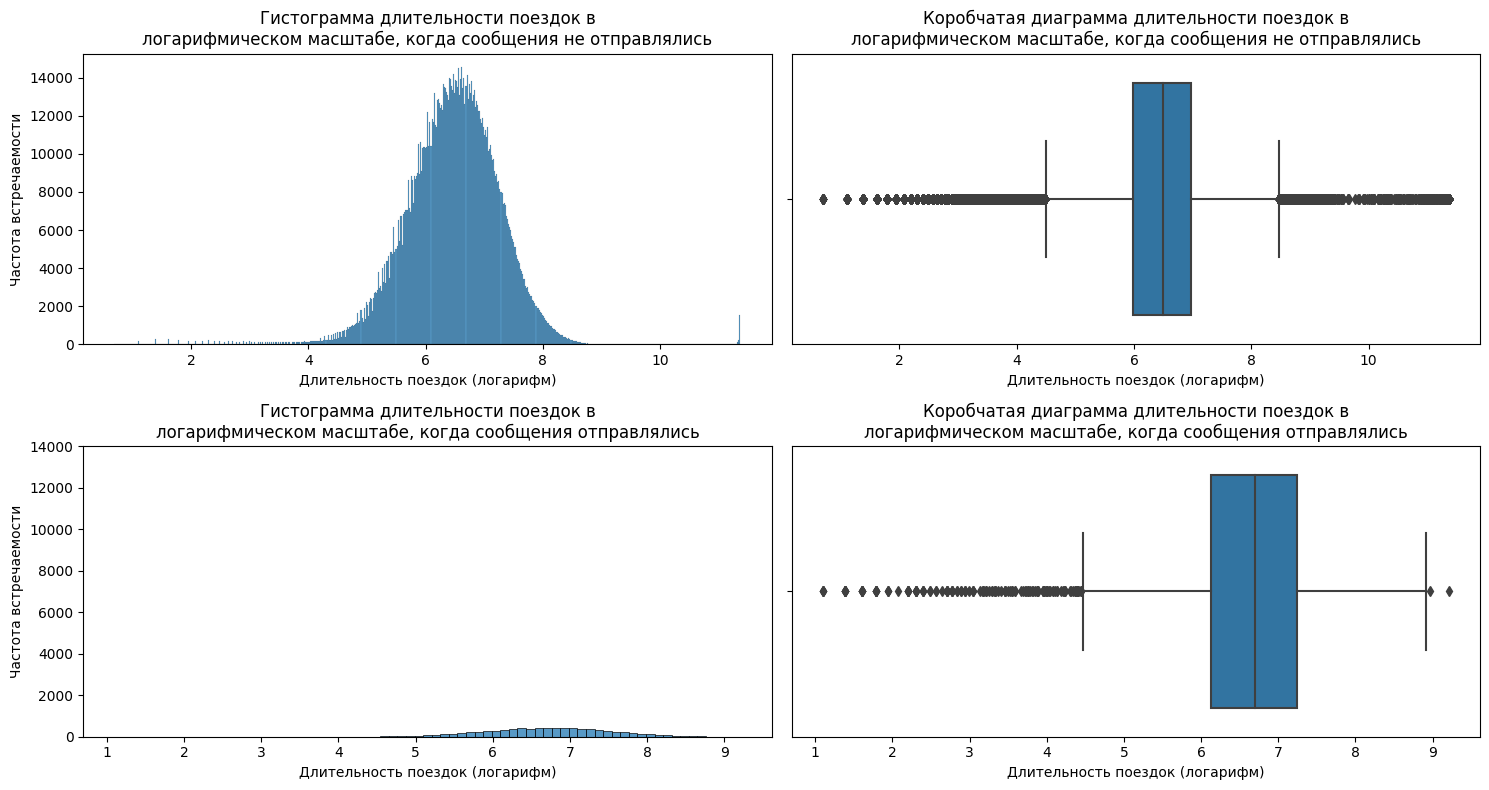

In [19]:
figure, axes = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(data=taxi_data_mod[taxi_data_mod['store_and_fwd_flag'] == 'N'], x='trip_duration_log', ax=axes[0][0])
axes[0][0].set_title('Гистограмма длительности поездок в\nлогарифмическом масштабе, когда сообщения не отправлялись')
axes[0][0].set_xlabel('Длительность поездок (логарифм)')
axes[0][0].set_ylabel('Частота встречаемости')

sns.boxplot(data=taxi_data_mod[taxi_data_mod['store_and_fwd_flag'] == 'N'], x='trip_duration_log', ax=axes[0][1])
axes[0][1].set_title('Коробчатая диаграмма длительности поездок в\nлогарифмическом масштабе, когда сообщения не отправлялись')
axes[0][1].set_xlabel('Длительность поездок (логарифм)');

sns.histplot(data=taxi_data_mod[taxi_data_mod['store_and_fwd_flag'] == 'Y'], x='trip_duration_log', ax=axes[1][0])
axes[1][0].set_title('Гистограмма длительности поездок в\nлогарифмическом масштабе, когда сообщения отправлялись')
axes[1][0].set_xlabel('Длительность поездок (логарифм)')
axes[1][0].set_ylabel('Частота встречаемости')
axes[1][0].set_ybound(upper=14000)

sns.boxplot(data=taxi_data_mod[taxi_data_mod['store_and_fwd_flag'] == 'Y'], x='trip_duration_log', ax=axes[1][1])
axes[1][1].set_title('Коробчатая диаграмма длительности поездок в\nлогарифмическом масштабе, когда сообщения отправлялись')
axes[1][1].set_xlabel('Длительность поездок (логарифм)')

plt.tight_layout();

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

### 3.4.
Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

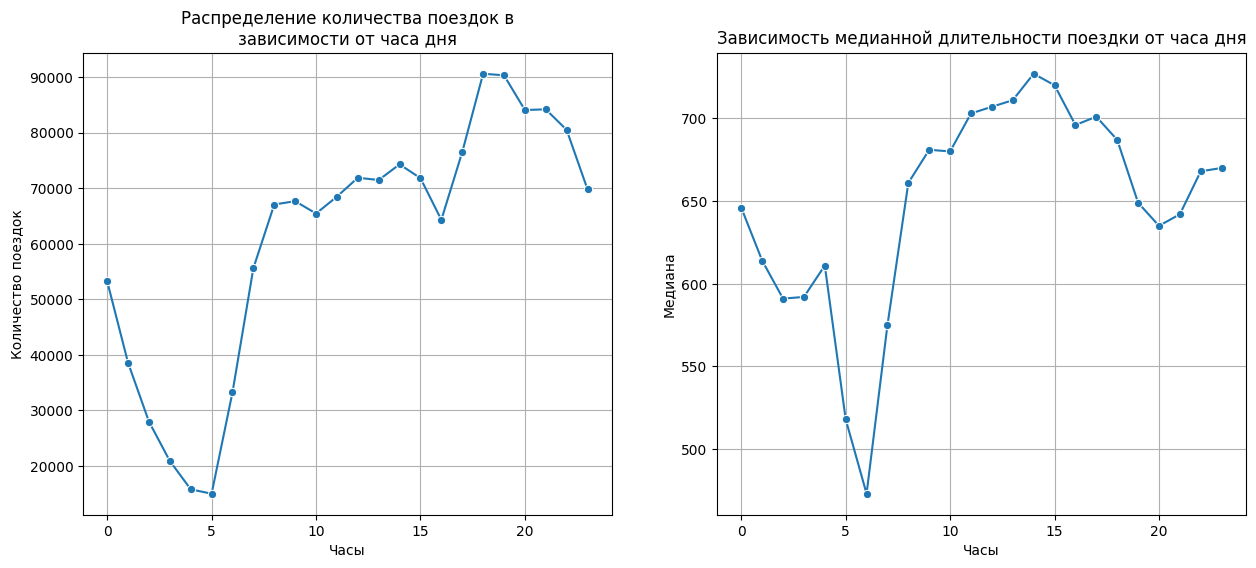

In [20]:
taxi_at_hour = taxi_data_mod.pivot_table(
    index='pickup_hour',
    values='trip_duration',
    aggfunc=['count', 'median']
)

figure, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x=taxi_at_hour.index, y=taxi_at_hour['count'].values.reshape((24, )), marker='o', ax=axes[0])
axes[0].set_title('Распределение количества поездок в\nзависимости от часа дня')
axes[0].set_xlabel('Часы')
axes[0].set_ylabel('Количество поездок')
axes[0].grid(True, linestyle='-')
sns.lineplot(x=taxi_at_hour.index, y=taxi_at_hour['median'].values.reshape((24, )), marker='o', ax=axes[1])
axes[1].set_title('Зависимость медианной длительности поездки от часа дня')
axes[1].set_xlabel('Часы')
axes[1].set_ylabel('Медиана')
axes[1].grid(True, linestyle='-');

С 00:00 по 05:00 такси заказывают реже всего.

С 13:00 по 18:00 наблюдается пик медианной длительности поездок.

### 3.5.
Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


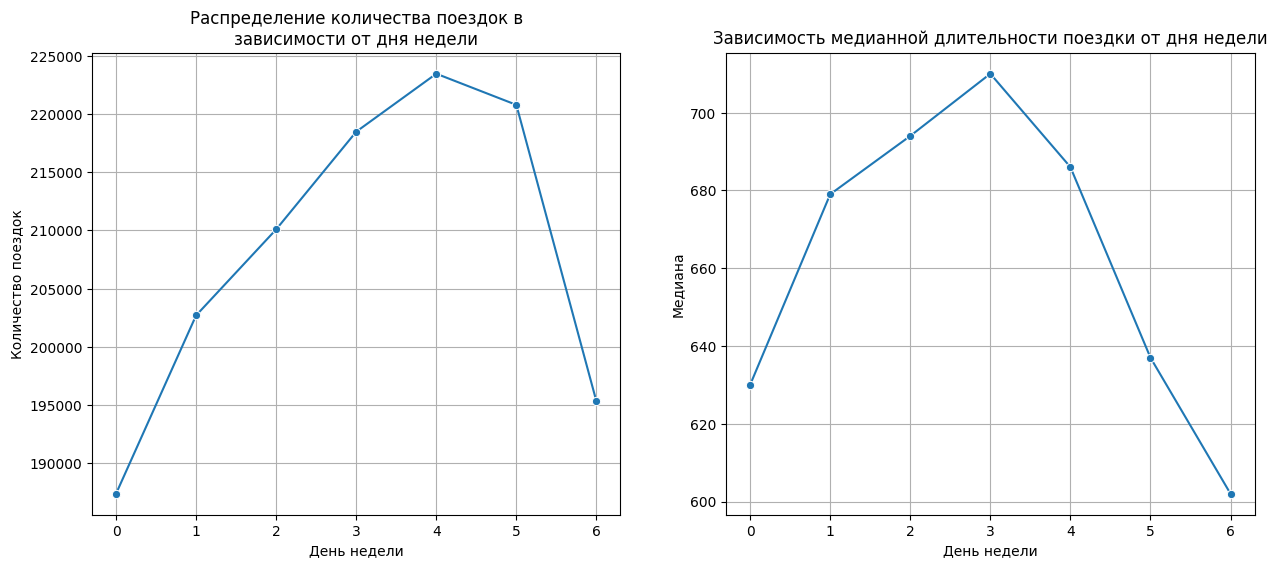

In [21]:
taxi_at_day = taxi_data_mod.pivot_table(
    index='pickup_day_of_week',
    values='trip_duration',
    aggfunc=['count', 'median']
)

figure, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x=taxi_at_day.index, y=taxi_at_day['count'].values.reshape((7, )), marker='o', ax=axes[0])
axes[0].set_title('Распределение количества поездок в\nзависимости от дня недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество поездок')
axes[0].grid(True, linestyle='-')
sns.lineplot(x=taxi_at_day.index, y=taxi_at_day['median'].values.reshape((7, )), marker='o', ax=axes[1])
axes[1].set_title('Зависимость медианной длительности поездки от дня недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Медиана')
axes[1].grid(True, linestyle='-');

В пятницу совершается больше всего поездок.

В воскресенье медианная длительность поездок наименьшая.

### 3.6.
Посмотрим на обе временные характеристики одновременно.

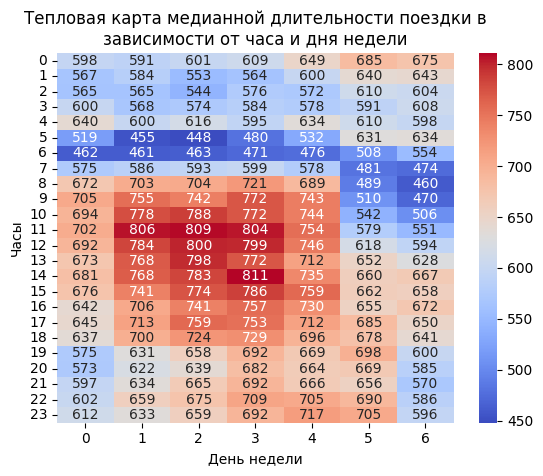

In [22]:
taxi_at_hour_and_day = taxi_data_mod.pivot_table(
    index='pickup_hour',
    columns='pickup_day_of_week',
    values='trip_duration',
    aggfunc='median'
)

ax = plt.subplot()
sns.heatmap(data=taxi_at_hour_and_day, cmap='coolwarm', annot=True, fmt=".3g");
ax.set_title('Тепловая карта медианной длительности поездки в\nзависимости от часа и дня недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Часы');

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.

Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### 3.7.
Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые были сгенерированы ранее.


/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


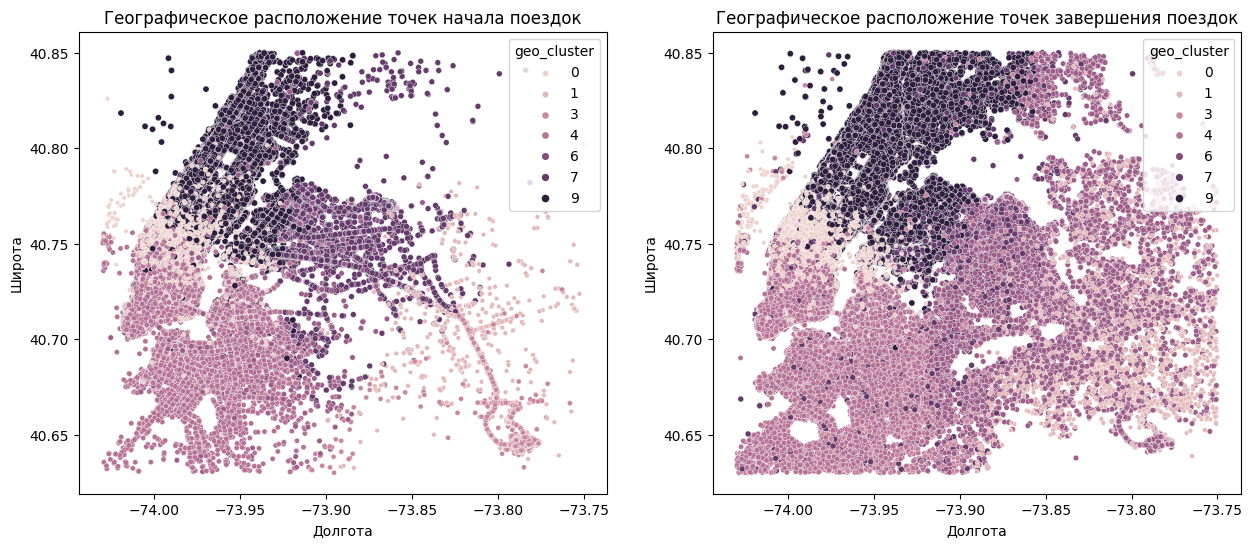

In [23]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

taxi_new_york = taxi_data_mod[
    (taxi_data_mod['pickup_longitude'] > city_long_border[0]) &
    (taxi_data_mod['pickup_longitude'] < city_long_border[1]) &
    (taxi_data_mod['dropoff_longitude'] > city_long_border[0]) &
    (taxi_data_mod['dropoff_longitude'] < city_long_border[1]) &
    (taxi_data_mod['pickup_latitude'] > city_lat_border[0]) &
    (taxi_data_mod['pickup_latitude'] < city_lat_border[1]) &
    (taxi_data_mod['dropoff_latitude'] > city_lat_border[0]) &
    (taxi_data_mod['dropoff_latitude'] < city_lat_border[1])]

figure, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=taxi_new_york, x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', ax=axes[0], size='geo_cluster', sizes=(10, 20))
axes[0].set_title('Географическое расположение точек начала поездок')
axes[0].set_xlabel('Долгота')
axes[0].set_ylabel('Широта')
sns.scatterplot(data=taxi_new_york, x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', ax=axes[1], size='geo_cluster', sizes=(10, 20))
axes[1].set_title('Географическое расположение точек завершения поездок')
axes[1].set_xlabel('Долгота')
axes[1].set_ylabel('Широта');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Закодировать признаки;
* Отобрать признаки, которые будут использоваться для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


Для удобства работы сделаем копию исходной таблицы с поездками:

In [24]:
train_data = taxi_data_mod.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### 4.1.
Исключим очевидно неинформативные и избыточные признаки из исходной таблицы с данными.

In [25]:
train_data = train_data.drop(columns=['id', 'dropoff_datetime'])
print('Осталось столбцов:', train_data.shape[1])

Осталось столбцов: 25


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [26]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Получившаяся размерность:  {}'.format(train_data.shape))

Получившаяся размерность:  (1458233, 23)


### 4.2.
Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитаем среднее по закодированному столбцу vendor_id.

б) Рассчитаем среднее по закодированному столбцу store_and_fwd_flag.

In [27]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda arg: 0 if arg == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda arg: 0 if arg == 'N' else 1)
print('Среднее по закодированному столбцу vendor_id - ', np.round(train_data['vendor_id'].mean(), 2))
print('Среднее по закодированному столбцу store_and_fwd_flag - ', np.round(train_data['store_and_fwd_flag'].mean(), 3))

Среднее по закодированному столбцу vendor_id -  0.53
Среднее по закодированному столбцу store_and_fwd_flag -  0.006


### 4.3.
Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder.

Сколько бинарных столбцов получилось сгенерировать с помощью однократного кодирования?

In [28]:
one_hot_encoder = preprocessing.OneHotEncoder(drop='first').fit(train_data[['pickup_day_of_week', 'geo_cluster', 'events']])
data_onehot = one_hot_encoder.transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
data_onehot = pd.DataFrame(data_onehot, columns=one_hot_encoder.get_feature_names_out())
data_onehot.head()

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [29]:
print('Сгенерировано {0} бинарных столбцов.'.format(data_onehot.shape[1]))

Сгенерировано 18 бинарных столбцов.


Добавим полученную таблицу с закодированными признаками:

In [30]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns=['pickup_day_of_week', 'geo_cluster', 'events'], axis=1), data_onehot], 
    axis=1
)
print('Получившаяся размерность: {}'.format(train_data.shape))

Получившаяся размерность: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [31]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [32]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### 4.4.
Отберём 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.

Укажем признаки, которые вошли в список отобранных.


In [33]:
k_best = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)
k_best.fit(X_train, y_train_log)
selected_features = k_best.get_feature_names_out()
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]
print(selected_features)

['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_3' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


### 4.5.
Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler.

Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки.


In [34]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train, y_train_log)
X_train_scaled = pd.DataFrame(data=mm_scaler.transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(data=mm_scaler.transform(X_valid), columns=X_valid.columns)
print('Среднее арифметическое для первого предиктора из валидационной выборки равно {0}.'.format(
    np.round(X_valid_scaled[X_valid_scaled.columns[0]].mean(), 2)))

Среднее арифметическое для первого предиктора из валидационной выборки равно 0.54.


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой будем измерять качество моделей. В качестве метрики будем использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### 5.1.
Построим модель линейной регрессии.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [35]:
def rmsle(y_true: float, y_pred: float):
    """Функция считает значение ошибки RMSLE.

    Args:
        y_true (float): истинное значение целевой переменной (логарифм).
        y_pred (float): предсказанное значение (логарифм).

    Returns:
        float: Значение ошибки RMSLE.
    """
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

In [36]:
lin_model = linear_model.LinearRegression()
lin_model.fit(X_train_scaled, y_train_log)
y_pred_train = lin_model.predict(X_train_scaled)
print('RMSLE на тренировочной выборке:', np.round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = lin_model.predict(X_valid_scaled)
print('RMSLE на валидационной выборке:', np.round(rmsle(y_valid_log, y_pred_valid), 2))

RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### 5.2.
Сгенерируем полиномиальные признаки 2-ой степени.

Построим модель полиномиальной регрессии 2-ой степени.

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

б) Наблюдаются ли у модели признаки переобучения?


In [37]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = pd.DataFrame(data=poly.fit_transform(X_train_scaled, y_train_log), columns=poly.get_feature_names_out())
poly_model = linear_model.LinearRegression()
poly_model.fit(X_train_poly, y_train_log)
y_pred_train_poly = poly_model.predict(X_train_poly)
print('RMSLE на тренировочной выборке с полиномиальными признаками:', np.round(rmsle(y_train_log, y_pred_train_poly), 2))

X_valid_poly = pd.DataFrame(data=poly.fit_transform(X_valid_scaled, y_valid_log), columns=poly.get_feature_names_out())
y_pred_valid_poly = poly_model.predict(X_valid_poly)
print('RMSLE на валидационной выборке с полиномиальными признаками:', np.round(rmsle(y_valid_log, y_pred_valid_poly), 2))

RMSLE на тренировочной выборке с полиномиальными признаками: 0.47
RMSLE на валидационной выборке с полиномиальными признаками: 0.7


Судя по метрикам, можем сказать, что у нас наблюдается переобучение.

### 5.3.
Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову).

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [38]:
ridge_regularization = linear_model.Ridge()
ridge_regularization.fit(X_train_poly, y_train_log)
y_pred_train_l2 = ridge_regularization.predict(X_train_poly)
print('RMSLE на тренировочной выборке с полиномиальными признаками и L2-регуляризацией:', np.round(rmsle(y_train_log, y_pred_train_l2), 2))
y_pred_valid_l2 = ridge_regularization.predict(X_valid_poly)
print('RMSLE на валидационной выборке с полиномиальными признаками и L2-регуляризацией:', np.round(rmsle(y_valid_log, y_pred_valid_l2), 2))

RMSLE на тренировочной выборке с полиномиальными признаками и L2-регуляризацией: 0.48
RMSLE на валидационной выборке с полиномиальными признаками и L2-регуляризацией: 0.48


### 5.4.
Построим модель дерева решений.

а) Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

б) Наблюдаются ли у модели признаки переобучения?

In [39]:
decision_tree = tree.DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train_scaled, y_train_log)
y_pred_train_tree = decision_tree.predict(X_train_scaled)
print('RMSLE дерева решений на тренировочной выборке:', np.round(rmsle(y_train_log, y_pred_train_tree), 2))
y_pred_valid_tree = decision_tree.predict(X_valid_scaled)
print('RMSLE дерева решений на валидационной выборке:', np.round(rmsle(y_valid_log, y_pred_valid_tree), 2))

RMSLE дерева решений на тренировочной выборке: 0.0
RMSLE дерева решений на валидационной выборке: 0.57


Так же, как и в случае с полиномиальной регрессией, мы наблюдаем переобучение данной модели, причём в более явном виде.

### 5.5.
Переберём все возможные варианты глубины дерева решений в диапазоне от 7 до 20.

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдём оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной?


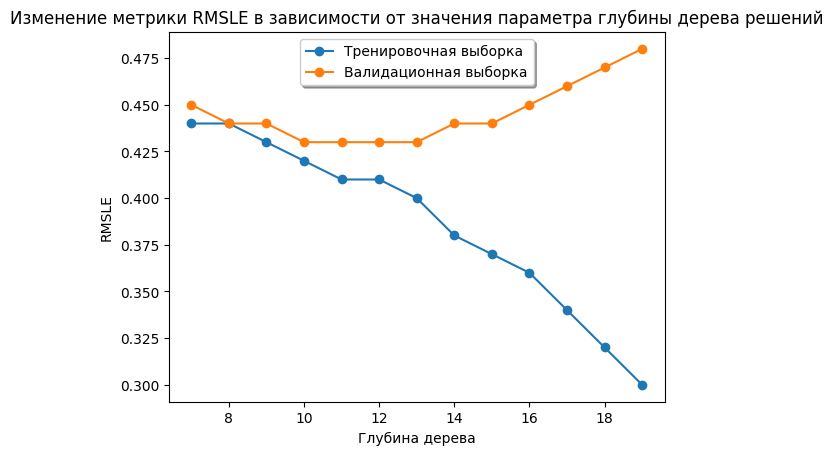

In [40]:
max_depths = range(7, 20)
train_errors, valid_errors = [], []
for depth in max_depths:
    decision_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    decision_tree.fit(X_train_scaled, y_train_log)
    y_pred_train_tree = decision_tree.predict(X_train_scaled)
    train_errors.append(np.round(rmsle(y_train_log, y_pred_train_tree), 2))
    y_pred_valid_tree = decision_tree.predict(X_valid_scaled)
    valid_errors.append(np.round(rmsle(y_valid_log, y_pred_valid_tree), 2))

figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(max_depths, train_errors, label='Тренировочная выборка', marker='o')
ax.plot(max_depths, valid_errors, label='Валидационная выборка', marker='o')
ax.set_title('Изменение метрики RMSLE в зависимости от значения параметра глубины дерева решений')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('RMSLE')
legend = ax.legend(loc='upper center', shadow=True)

Итак, что мы видим на этом графике? До максимальной глубины, равной 13, мы наблюдаем невозрастание ошибки на валидационном наборе. После неё, то есть начиная с 14, ошибка на валидационном наборе начинает расти. Видим также, что ошибка при глубине 9 больше, чем при глубине 10, а от 10 до 13 включительно ошибка остаётся неизменной. Однако при глубине 13 разность между ошибками на тренировочном и валидационном наборах больше, чем та же разность при глубинах 11 и 12. При глубине 10 разница между ошибками еще меньше, однако в таком случае ошибка на тренировочном наборе выше, чем при глубинах 11 и 12. В итоге получаем, что значения максимальных глубин 11 и 12 являются самыми оптимальными среди всех рассматриваемых глубин. Давайте в качестве оптимальной возьмём глубину, равной 12.

In [41]:
print('RMSLE на тренировочной выборке при максимальной глубине дерева решений, равной {0}.'.format(train_errors[12 - 7]))
print('RMSLE на тренировочной выборке при максимальной глубине дерева решений, равной {0}.'.format(valid_errors[12 - 7]))

RMSLE на тренировочной выборке при максимальной глубине дерева решений, равной 0.41.
RMSLE на тренировочной выборке при максимальной глубине дерева решений, равной 0.43.


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### 6.1.

Построим модель случайного леса.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [59]:
random_forest = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True
)
%time
random_forest.fit(X_train_scaled, y_train_log)
y_pred_train_forest = random_forest.predict(X_train_scaled)
print('RMSLE случайного леса на тренировочном наборе:', np.round(rmsle(y_train_log, y_pred_train_forest), 2))
y_pred_valid_forest = random_forest.predict(X_valid_scaled)
print('RMSLE случайного леса на валидационном наборе:', np.round(rmsle(y_valid_log, y_pred_valid_forest), 2))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 17.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE случайного леса на тренировочном наборе: 0.4
RMSLE случайного леса на тренировочном наборе: 0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.1s finished


### 6.2.
Построим модель градиентного бустинга над деревьями решений.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [60]:
grad_boosting = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)
grad_boosting.fit(X_train_scaled, y_train_log)
y_pred_train_boosting = grad_boosting.predict(X_train_scaled)
print('RMSLE градиентного бустинга на тренировочном наборе:', np.round(rmsle(y_train_log, y_pred_train_boosting), 2))
y_pred_valid_boosting = grad_boosting.predict(X_valid_scaled)
print('RMSLE градиентного бустинга на валидационном наборе:', np.round(rmsle(y_valid_log, y_pred_valid_boosting), 2))

      Iter       Train Loss   Remaining Time 
         1           0.3110            7.27m
         2           0.2247            7.20m
         3           0.1987            7.12m
         4           0.1876            7.05m
         5           0.1823            7.00m
         6           0.1783            6.91m
         7           0.1756            6.85m
         8           0.1730            6.76m
         9           0.1709            6.68m
        10           0.1696            6.60m
        20           0.1577            5.84m
        30           0.1538            5.09m
        40           0.1502            4.35m
        50           0.1480            3.62m
        60           0.1451            2.90m
        70           0.1431            2.17m
        80           0.1410            1.45m
        90           0.1393           43.36s
       100           0.1383            0.00s
RMSLE градиентного бустинга на тренировочном наборе: 0.37
RMSLE градиентного бустинга на валидацион

### 6.3.
Среди всех построенных моделей наилучший результат показала модель градиентного бустинга над деревьями решений.


### 6.4.
Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажем топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.

/var/folders/9w/0qdzk64s4ss73vm8r09d7h9h0000gn/T/ipykernel_926/4280923932.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=X_train_scaled.columns, rotation=90);


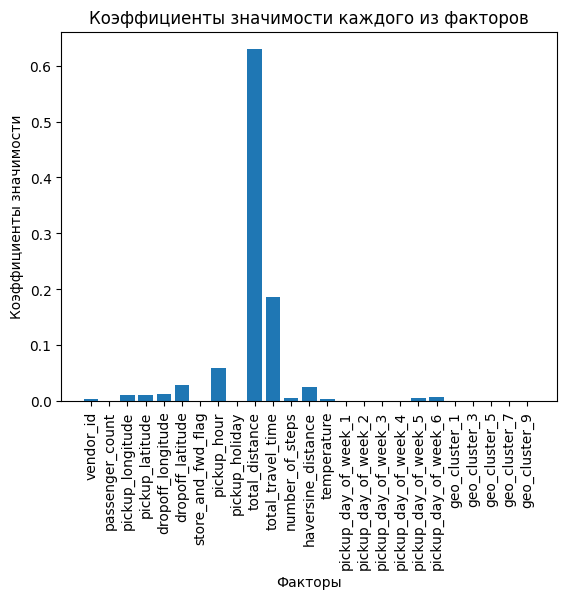

In [72]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.bar(x=X_train_scaled.columns, height=grad_boosting.feature_importances_)
ax.set_title('Коэффициенты значимости каждого из факторов')
ax.set_xlabel('Факторы')
ax.set_ylabel('Коэффициенты значимости')
ax.set_xticklabels(labels=X_train_scaled.columns, rotation=90);

Топ-3 наиболее значимых для предсказания факторов - total_distance, total_travel_time и pickup_hour.

### 6.5.
Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведём в минуты и округлим до десятых.


In [73]:
y_valid = np.exp(y_valid_log) - 1
y_pred_valid_boosting_not_log = np.exp(y_pred_valid_boosting) - 1
print('MeAE градиентного бустинга на валидационном наборе (целевая переменная и предсказание в НЕ логарифмическом масштабе) (в минутах) - ',
      np.round(metrics.median_absolute_error(y_valid, y_pred_valid_boosting_not_log) / 60, 1))

MeAE градиентного бустинга на валидационном наборе (целевая переменная и предсказание в НЕ логарифмическом масштабе) (в минутах) -  1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных.

In [75]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые были производены с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.

In [79]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)
X_test = test_data[selected_features]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудем перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

In [80]:
y_test_predict = grad_boosting.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

/Users/familyafanasyevy/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **В качестве бонуса**

В завершение по ансамблевым моделям попробуем улучшить предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.


In [81]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [82]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=selected_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [83]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93551	valid-rmse:1.93540
[20]	train-rmse:0.78578	valid-rmse:0.78657
[30]	train-rmse:0.47960	valid-rmse:0.48157
[40]	train-rmse:0.42165	valid-rmse:0.42428
[50]	train-rmse:0.40946	valid-rmse:0.41250
[60]	train-rmse:0.40477	valid-rmse:0.40823
[70]	train-rmse:0.40100	valid-rmse:0.40480
[80]	train-rmse:0.39879	valid-rmse:0.40290
[90]	train-rmse:0.39745	valid-rmse:0.40183
[100]	train-rmse:0.39615	valid-rmse:0.40079
[110]	train-rmse:0.39439	valid-rmse:0.39932
[120]	train-rmse:0.39321	valid-rmse:0.39844
[130]	train-rmse:0.39221	valid-rmse:0.39766
[140]	train-rmse:0.39114	valid-rmse:0.39711
[150]	train-rmse:0.39004	valid-rmse:0.39637
[160]	train-rmse:0.38907	valid-rmse:0.39561
[170]	train-rmse:0.38811	valid-rmse:0.39495
[180]	train-rmse:0.38730	valid-rmse:0.39440
[190]	train-rmse:0.38671	valid-rmse:0.39420
[200]	train-rmse:0.38596	valid-rmse:0.39384
[210]	train-rmse:0.38515	valid-rmse:0.39346
[220]	train-rmse:0.38420	valid-rmse:0.39292

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [84]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39119


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

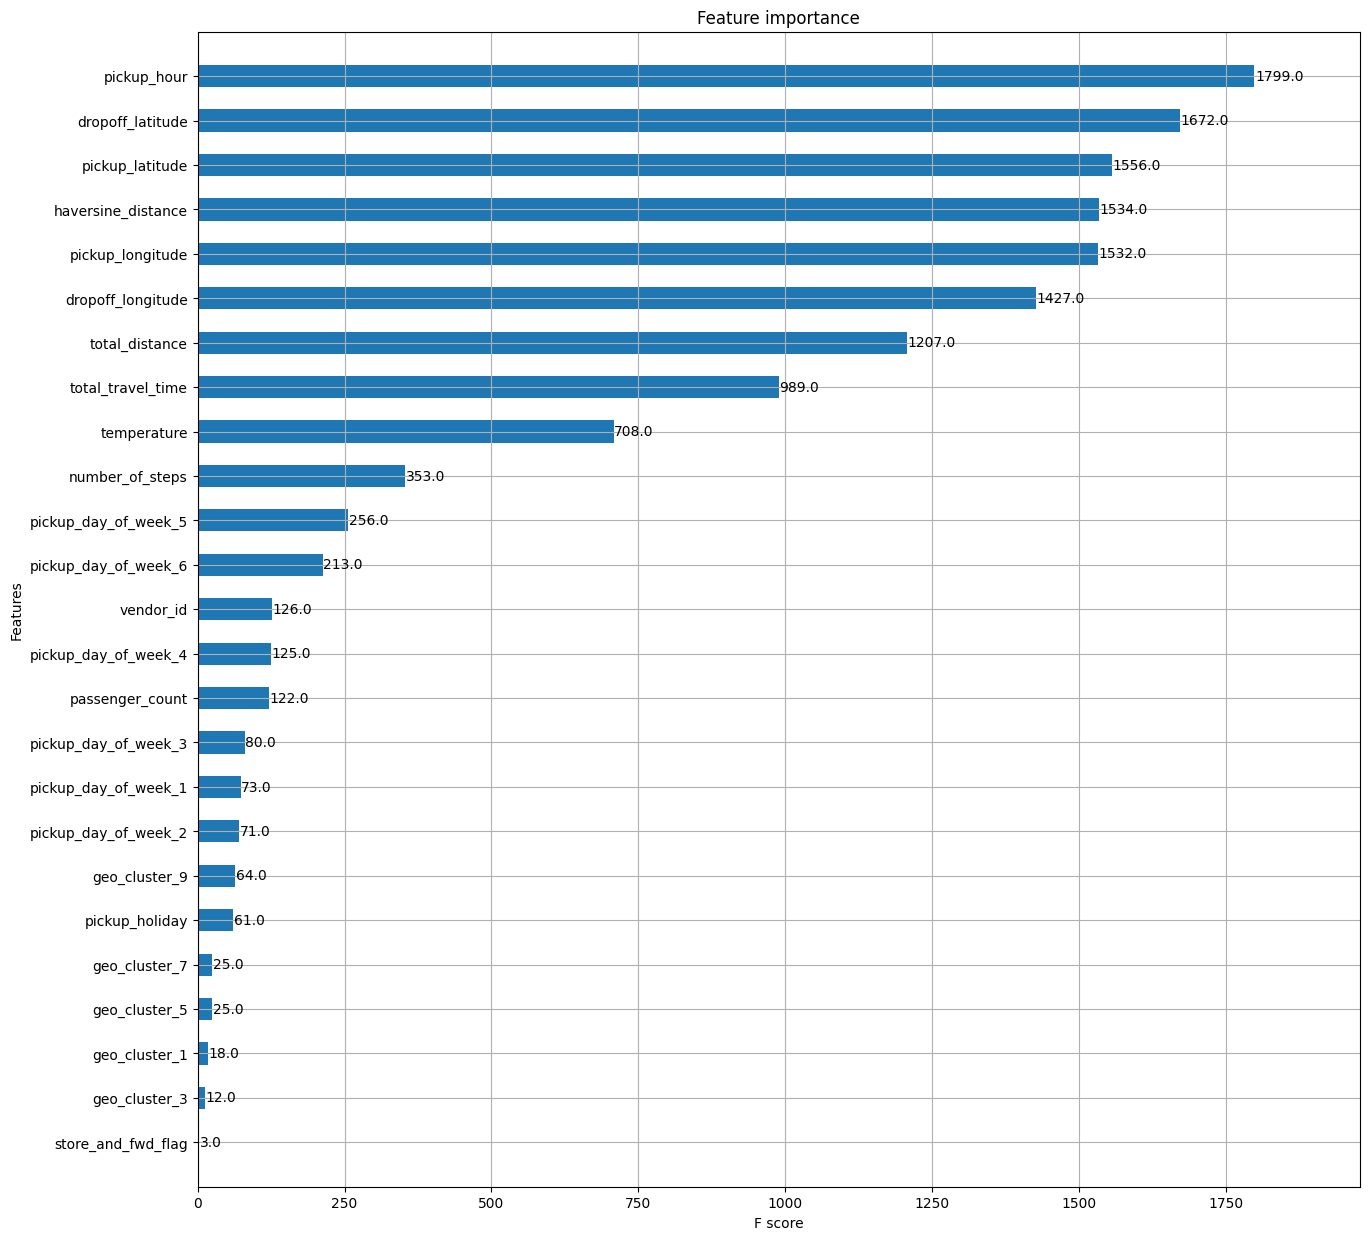

In [85]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)